# PRACTICO 1 - Regresión Logistica

ALUMNO: Torres Loayza Alberto Antonio

En este ejercicio implementaremos regresión logística y la aplicaremos a un conjunto de datos de cáncer de mama para clasificar tumores como benignos o malignos basados en características celulares.

In [7]:
import numpy as np
from matplotlib import pyplot
import pandas as pd
%matplotlib inline

## 1 Regresion Logistica

En esta parte del ejercicio, crearemos un modelo de regresión logística para predecir si un tumor es benigno o maligno. Los datos contienen características de células extraídas de biopsias, y nuestro objetivo es crear un modelo de clasificación que calcule la probabilidad de malignidad basado en estas características.

La siguiente celda cargará los datos y las etiquetas correspondientes:

In [30]:
# Cargamos los datos
data = pd.read_csv('breast_cancer.csv')

# En el conjunto de datos original, 2 = benigno, 4 = maligno
# Vamos a convertir estos a 0 (benigno) y 1 (maligno) para facilitar la implementación
data['Class'] = data['Class'].map({2: 0, 4: 1})
print("\nDistribución de clases después de la transformación:")
print(data['Class'].value_counts())

# Extraemos las características y las etiquetas
X = data.iloc[:, :-1].values  # Todas las columnas excepto la última
y = data.iloc[:, -1].values   # Solo la última columna (Class)

print("\nPrimeras 5 filas de características:")
print(X[:5])
print("\nPrimeras 5 etiquetas:")
print(y[:5])


Distribución de clases después de la transformación:
Class
0    444
1    239
Name: count, dtype: int64

Primeras 5 filas de características:
[[ 5  1  1  1  2  1  3  1  1]
 [ 5  4  4  5  7 10  3  2  1]
 [ 3  1  1  1  2  2  3  1  1]
 [ 6  8  8  1  3  4  3  7  1]
 [ 4  1  1  3  2  1  3  1  1]]

Primeras 5 etiquetas:
[0 0 0 0 0]


### 1.1 Visualizar los datos

Antes de comenzar a implementar cualquier algoritmo de aprendizaje, es bueno visualizar los datos si es posible. Vamos a mostrar algunas de las características más relevantes para ver cómo se distribuyen los datos.

In [14]:
def plotData(X, y):
    """
    Grafica los puntos de datos X y <y> en una nueva figura. 
    Grafica los puntos con + para los casos positivos (malignos) y 
    o para los negativos (benignos).
    
    Parámetros
    ----------
    X : array_like
        Los puntos de datos. En este caso tomamos dos características para visualización.
    
    y : array_like
        Las etiquetas de clase (0 o 1).
    """
    # Crear una nueva figura
    fig = pyplot.figure()

    # Encontrar índices de ejemplos positivos y negativos
    pos = y == 1
    neg = y == 0

    # Graficar ejemplos
    pyplot.scatter(X[pos, 0], X[pos, 1], marker='+', c='k', s=60, linewidth=2)
    pyplot.scatter(X[neg, 0], X[neg, 1], marker='o', c='y', s=40, edgecolors='k')


Se llama a la función implementada para mostrar los datos cargados:

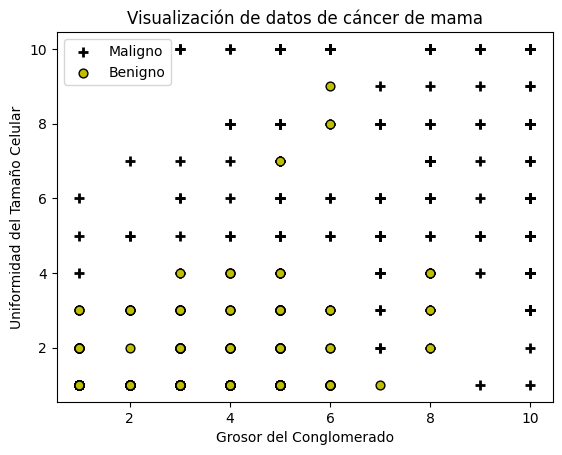

In [15]:
# Vamos a seleccionar dos características para visualización
# Para este ejemplo usamos 'Clump Thickness' y 'Uniformity of Cell Size'
X_viz = X[:, :2]
plotData(X_viz, y)
pyplot.xlabel('Grosor del Conglomerado')
pyplot.ylabel('Uniformidad del Tamaño Celular')
pyplot.legend(['Maligno', 'Benigno'])
pyplot.title('Visualización de datos de cáncer de mama')
pyplot.show()

<a id="section1"></a>
### 1.2 Implementacion

#### 1.2.1 Fución Sigmoidea

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$ g(z) = \frac{1}{1+e^{-z}}$$

Los resultados que debe generar la funcion sigmoidea para valores positivos amplios de `x`, deben ser cercanos a 1, mientras que para valores negativos grandes, la sigmoide debe generar valores cercanos 0. La evaluacion de `sigmoid(0)` debe dar un resultado exacto de 0.5. Esta funcion tambien debe poder trabajar con vectores y matrices.

In [17]:
def sigmoid(z):
    """
    Calcula la sigmoide de una entrada z
    """
    # Convierte la entrada a un arreglo numpy
    z = np.array(z)

    g = np.zeros(z.shape)

    g = 1 / (1 + np.exp(-z))

    return g

Se calcula el valor de la sigmoide aplicando la funcion sigmoid con `z=0`, se debe obtener un resultado de 0.5. RE recomienda experimentar con otros valores de `z`.

In [8]:
# Prueba la implementacion de la funcion sigmoid
z = [0, 0.5, 1]
g = sigmoid(z)

print('g(', z, ') = ', g)

g( [0, 0.5, 1] ) =  [0.5        0.62245933 0.73105858]


<a id="section2"></a>
#### 1.2.2 Función de Costo y Gradiente

Primero, agregaremos una columna de unos a X para incorporar el término de intercepción.


In [18]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
X = np.concatenate([np.ones((m, 1)), X], axis=1)

La funcion de costo en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

In [19]:
def calcularCosto(theta, X, y):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística
    """
    # Inicializar algunos valores útiles
    m = y.size  # número de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J

In [20]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    """
    Implementa el descenso por el gradiente para aprender theta
    """
    # Inicializa algunos valores
    m = y.shape[0] # número de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será actualizado por el descenso por el gradiente
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)

        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history

In [21]:
def costFunction(theta, X, y):
    """
    Calcula el costo y el gradiente para regresión logística
    """
    # Inicializar algunos valores útiles
    m = y.size  # número de ejemplos de entrenamiento

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    grad = (1 / m) * (h - y).dot(X)

    return J, grad

Se prueba la funcion `costFunction` utilizando dos casos de prueba para $\theta$.

In [22]:
# Iniciamos los parámetros con ceros
initial_theta = np.zeros(n+1)
print("Parámetros iniciales:", initial_theta)

# Calculamos el costo con los parámetros iniciales
cost, grad = costFunction(initial_theta, X, y)

print('Costo con theta inicializado en ceros: {:.3f}'.format(cost))
print('Gradiente en theta inicial (primeros 5 valores):', grad[:5])

# Entrenamos el modelo con descenso de gradiente
alpha = 0.01
num_iters = 1000

theta, J_history = descensoGradiente(initial_theta, X, y, alpha, num_iters)


Parámetros iniciales: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Costo con theta inicializado en ceros: 0.693
Gradiente en theta inicial (primeros 5 valores): [ 0.15007321 -0.2942899  -0.72620791 -0.68814056 -0.53953148]


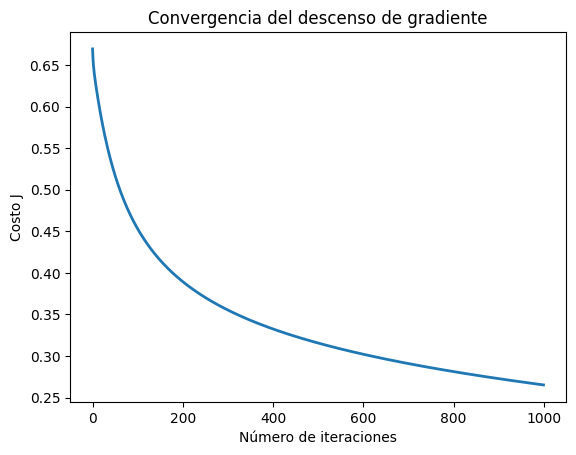

Theta calculado por el descenso por el gradiente: [-1.21488776 -0.21693041  0.51241996  0.26545463  0.12197112 -0.44783407
  0.41834477 -0.30463069  0.26755905 -0.14697741]


In [23]:
# Graficamos la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Número de iteraciones')
pyplot.ylabel('Costo J')
pyplot.title('Convergencia del descenso de gradiente')
pyplot.show()

# Mostramos los parámetros obtenidos
print('Theta calculado por el descenso por el gradiente:', theta)

#### 1.2.3 Evaluación del modelo

Después de aprender los parámetros, usaremos el modelo para predecir si un tumor con ciertas características es benigno o maligno. Evaluaremos la calidad de nuestro modelo viendo qué tan bien predice en nuestro conjunto de entrenamiento.

In [24]:
def predict(theta, X):
    """
    Predecir si la etiqueta es 0 o 1 mediante la regresión logística entrenada
    """
    m = X.shape[0] # Número de ejemplos de entrenamiento
    p = np.zeros(m)
    p = np.round(sigmoid(X.dot(theta.T)))
    return p

# Calculamos la precisión en el conjunto de entrenamiento
p = predict(theta, X)
print('Precisión del modelo en el conjunto de entrenamiento: {:.2f} %'.format(np.mean(p == y) * 100))


Precisión del modelo en el conjunto de entrenamiento: 93.85 %


In [25]:
# Ahora probemos un ejemplo específico
# Supongamos que tenemos un nuevo paciente con estos valores:
# Grosor del Conglomerado: 5
# Uniformidad del Tamaño Celular: 1
# ... (y así sucesivamente para todas las características)
# Recordemos que necesitamos agregar un 1 para el término de intercepción
ejemplo_nuevo = np.array([1, 5, 1, 1, 1, 2, 1, 3, 1, 1])
probabilidad_maligno = sigmoid(np.dot(ejemplo_nuevo, theta))
print('Para un paciente con las características dadas, la probabilidad de que el tumor sea maligno es: {:.2f}%'.format(probabilidad_maligno * 100))

Para un paciente con las características dadas, la probabilidad de que el tumor sea maligno es: 6.47%


### 1.3 Visualización de la Frontera de Decisión

Para visualizar mejor cómo funciona nuestra regresión logística, vamos a graficar la frontera de decisión.

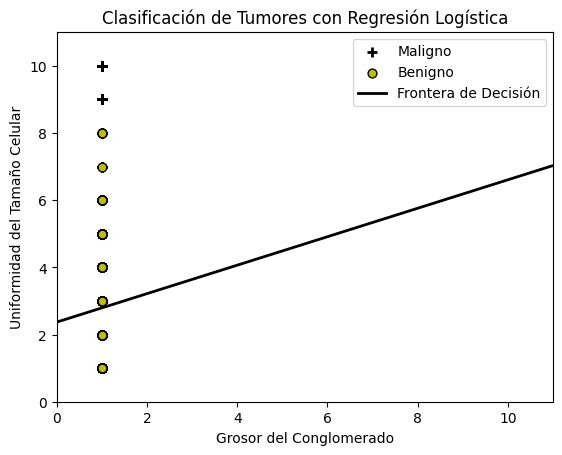

In [26]:
def plotDecisionBoundary(theta, X, y):
    """
    Grafica los puntos X y y en una nueva figura con la frontera de decisión
    definida por theta.
    
    Parámetros
    ----------
    theta : array_like
        Parámetros de la regresión logística.
        
    X : array_like
        Datos de entrada. Aquí solo usamos las dos primeras características.
        
    y : array_like
        Etiquetas de clase (0 o 1).
    """
    # Configuramos la figura
    plotData(X[:, :2], y)
    
    # Si X solo tiene dos características
    if X.shape[1] <= 3:
        # Calculamos dos puntos para dibujar la línea de decisión
        plot_x = np.array([min(X[:, 1])-2, max(X[:, 1])+2])
        
        # Calculamos los puntos correspondientes de y en la frontera de decisión
        # donde theta[0] + theta[1]*x1 + theta[2]*x2 = 0
        # Despejamos x2:
        # theta[2]*x2 = -theta[0] - theta[1]*x1
        # x2 = (-theta[0] - theta[1]*x1) / theta[2]
        plot_y = (-1.0 / theta[2]) * (theta[1] * plot_x + theta[0])
        
        # Graficamos y ajustamos los ejes para mejor visualización
        pyplot.plot(plot_x, plot_y, 'k-', linewidth=2)
        pyplot.xlim([X[:, 1].min()-1, X[:, 1].max()+1])
        pyplot.ylim([X[:, 2].min()-1, X[:, 2].max()+1])
        
        pyplot.xlabel('Grosor del Conglomerado')
        pyplot.ylabel('Uniformidad del Tamaño Celular')
        pyplot.legend(['Maligno', 'Benigno', 'Frontera de Decisión'])
        pyplot.title('Clasificación de Tumores con Regresión Logística')

# Necesitamos un conjunto simplificado de datos para visualizar (solo dos características)
X_viz_boundary = X[:, :3]  # Incluye la columna de unos y las dos primeras características reales
theta_viz = theta[:3]      # Solo los primeros tres parámetros de theta

plotDecisionBoundary(theta_viz, X_viz_boundary, y)
pyplot.show()